In [2]:
import hyperSLIC
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import numba as nb
from numba import jit
from tqdm import tqdm
%matplotlib qt5

In [3]:
s = hs.load(r"F:\March_ePSIC\SEd\dcdh_ultrathin_window01\20230309_181055\20230309_181055_calibrated_data.hspy",lazy=True)
#s = hs.load(r"C:\Users\tas72\Documents\PhD\synthetic_data\synthetic_data_circles.hspy", lazy=True)

In [3]:
constant = 10

In [ ]:
s.inav[:50,:50].isig[(s.axes_manager[2].size//2)-constant:(s.axes_manager[2].size//2)+constant,(s.axes_manager[3].size//2)-constant:(s.axes_manager[3].size//2)+constant].plot()

In [4]:
s = s.inav[:,:]
s.compute()

[########################################] | 100% Completed |  1min 36.3s


In [6]:
s.isig[(s.axes_manager[2].size//2)-constant:(s.axes_manager[2].size//2)+constant,(s.axes_manager[3].size//2)-constant:(s.axes_manager[3].size//2)+constant] = 0#np.zeros((constant*2,constant*2))

In [5]:
@jit(nopython=True)
def normalise(channel):
    channel = (channel - np.amin(channel))+1 # breaks if value of 0 is given
    channel = channel/np.amax(channel)
    return channel

def plot_ranges(raveled,percentile,bins, plot_or_not):
    reshaped = np.reshape(raveled, (np.shape(raveled)[0]*np.shape(raveled)[1], np.shape(raveled)[2]))
    ranges = np.ptp(reshaped, axis=0)
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    if plot_or_not == True:
        fig,ax = plt.subplots()
        ax.hist(ranges,density = True, bins = bins)
        plt.yscale('log')

        ax.axvline(percentile,linestyle = ":",color ='r' )

@jit(nopython = True)
def quick_wheat(ranges, reshaped, percentile):
    wheat = reshaped.T[ranges >= percentile]
    return wheat.T

def wheat_from_chaff(raveled, percentile):
    reshaped = np.reshape(raveled, (np.shape(raveled)[0]*np.shape(raveled)[1], np.shape(raveled)[2]))
    print('Reshaped')
    ranges = np.ptp(reshaped, axis=0)
    print('Ranges aquried')
    percentile = np.percentile(ranges,percentile)

    wheat = quick_wheat(ranges, reshaped, percentile)
    print('Wheat seperated')
    maxes = np.amax(wheat, axis=0)
    minis = np.amin(wheat,axis=0) 
    
    wheat = wheat - minis

    wheat = wheat/maxes
    
    wheat = np.reshape(wheat,(np.shape(raveled)[0],np.shape(raveled)[1],-1))
    return wheat

In [6]:
raveled = np.reshape(s.data, (s.axes_manager[0].size, s.axes_manager[1].size,s.axes_manager[2].size*s.axes_manager[3].size))

In [10]:
plot_ranges(raveled,97,50,True)

24.0


In [11]:
wheat = wheat_from_chaff(raveled,97)
print('Complete', np.shape(wheat))

Reshaped
Ranges aquried
Wheat seperated
Complete (255, 255, 7964)


In [12]:
wheat_hs = hs.signals.Signal1D(wheat)

In [17]:
test = hyperSLIC.SLIC(wheat_hs,'regular',250,1,1) # seed_num, m, searchspace

In [18]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
summed = s.T.sum().data
t0 = time.time()
for i in tqdm(range(50)):
    
    
    test.find_closest_centeroid()
    # if i%5 == 0:
    #     fig,ax = plt.subplots(1,3)
    #     ax[0].imshow(summed,cmap='gray')
    #     ax[1].imshow(test.closest_centeroid,cmap=cmap)
    #     ax[2].imshow(summed,cmap='gray')
    #     ax[2].imshow(test.closest_centeroid,cmap=cmap,alpha=0.25)
    #     ax[0].set_xticks([])
    #     ax[1].set_xticks([])
    #     ax[2].set_xticks([])
    #     ax[0].set_yticks([])
    #     ax[1].set_yticks([])
    #     ax[2].set_yticks([])
    test.update_centeroids()
    
t1 = time.time()
print(f'Time: {np.round((t1-t0),3)}s')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:38<00:00,  6.76s/it]

Time: 338.074s


In [25]:
centeroids = np.zeros((test.width,test.height))
for centeroid in test.xy_centeroids:
    centeroids[int(centeroid[0]),int(centeroid[1])] = 1
    
fig,ax = plt.subplots()
ax.imshow(centeroids,cmap='gray')

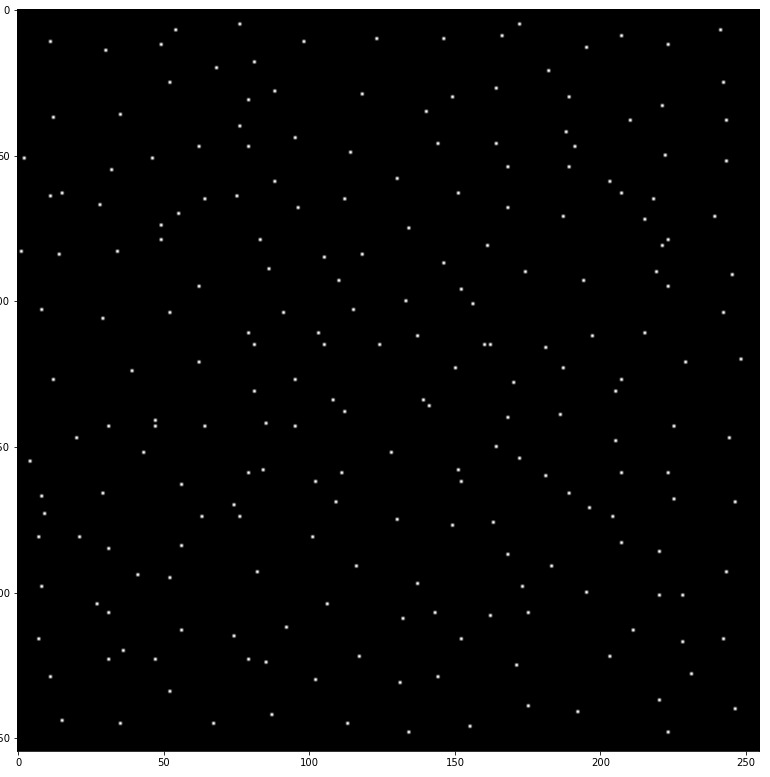

In [24]:
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))

fig,ax = plt.subplots(1,3)
ax[0].imshow(summed,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(summed,cmap='gray')
ax[2].imshow(test.closest_centeroid,cmap=cmap,alpha=0.25)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

[]

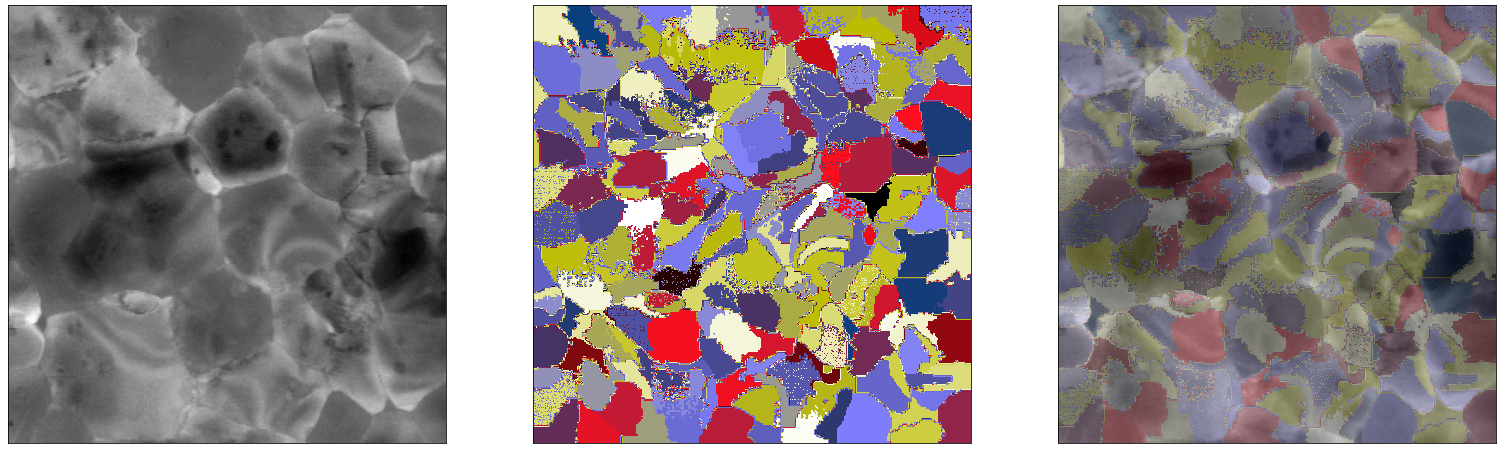

In [30]:
summed_patterns = np.zeros(test.k,dtype='object')
for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        arg = int(test.closest_centeroid[row,col])
        pattern = s.data[row,col]
        summed_patterns[arg]+=pattern

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:08<00:00, 28.49it/s]


In [34]:
fig,ax = plt.subplots(10,25)
for i in range(10):
    for j in range(25):
        try:
            ax[i,j].imshow(summed_patterns[i*25+j],vmax=15,cmap='Greys')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
        except:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=-0, hspace=0)
plt.show()


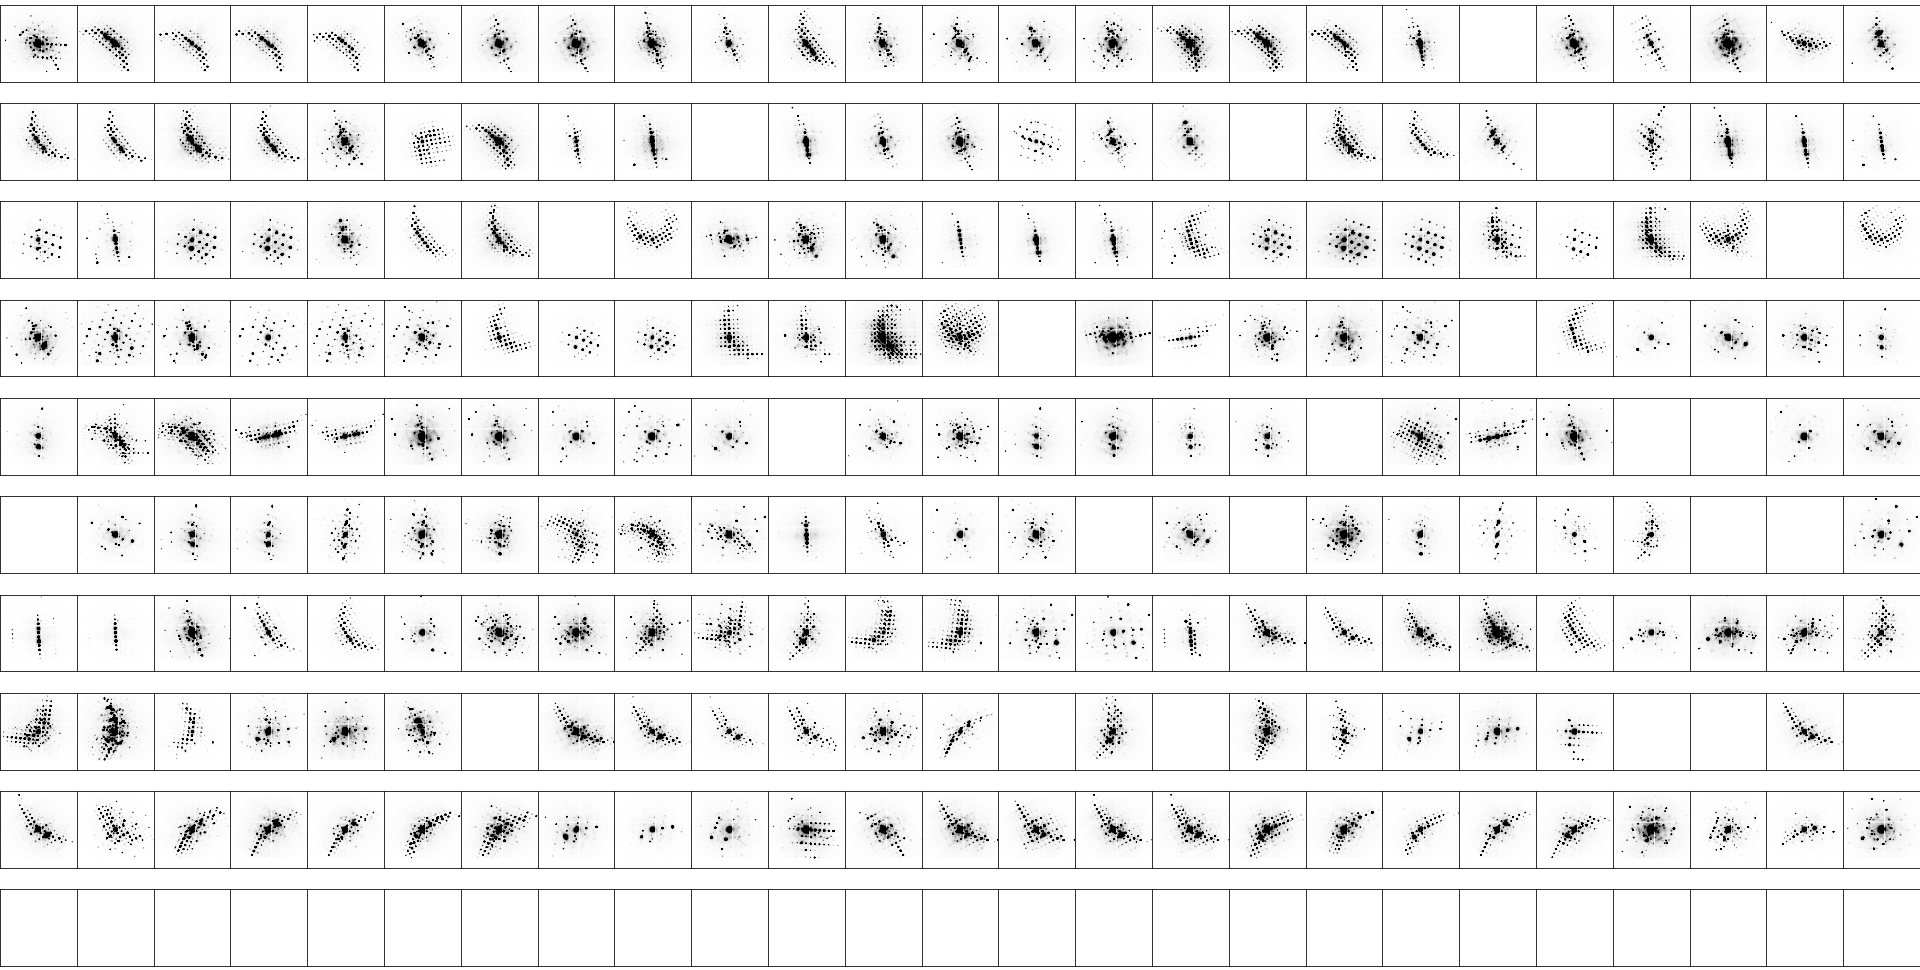